**LinkedIn:** https://www.linkedin.com/in/matheusjerico

## Análise de dados de logs de servidores

## 1. Importando bibliotecas

In [2]:
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import regexp_extract, col

## 2. Criando sessão

In [3]:
spSession = SparkSession.builder.master("local").appName("Analise de Dados").getOrCreate()

## 3. Carregando e Visualizando Dados

### 3.1 importando dados

In [4]:
dataset_julho = spSession.read.load("data/NASA_access_log_Jul95",
                                      format = "csv",
                                      sep = " ",
                                      inferSchema = "true",
                                      header = "false")

In [5]:
dataset_julho.show(n=5)

+--------------------+---+---+--------------------+------+--------------------+---+----+
|                 _c0|_c1|_c2|                 _c3|   _c4|                 _c5|_c6| _c7|
+--------------------+---+---+--------------------+------+--------------------+---+----+
|        199.72.81.55|  -|  -|[01/Jul/1995:00:0...|-0400]|GET /history/apol...|200|6245|
|unicomp6.unicomp.net|  -|  -|[01/Jul/1995:00:0...|-0400]|GET /shuttle/coun...|200|3985|
|      199.120.110.21|  -|  -|[01/Jul/1995:00:0...|-0400]|GET /shuttle/miss...|200|4085|
|  burger.letters.com|  -|  -|[01/Jul/1995:00:0...|-0400]|GET /shuttle/coun...|304|   0|
|      199.120.110.21|  -|  -|[01/Jul/1995:00:0...|-0400]|GET /shuttle/miss...|200|4179|
+--------------------+---+---+--------------------+------+--------------------+---+----+
only showing top 5 rows



In [6]:
dataset_agosto = spSession.read.load("data/NASA_access_log_Aug95",
                                      format = "csv",
                                      sep = " ",
                                      inferSchema = "true",
                                      header = "false")

In [7]:
dataset_agosto.show(n=5)

+-----------------+---+---+--------------------+------+--------------------+---+----+
|              _c0|_c1|_c2|                 _c3|   _c4|                 _c5|_c6| _c7|
+-----------------+---+---+--------------------+------+--------------------+---+----+
|in24.inetnebr.com|  -|  -|[01/Aug/1995:00:0...|-0400]|GET /shuttle/miss...|200|1839|
|  uplherc.upl.com|  -|  -|[01/Aug/1995:00:0...|-0400]|      GET / HTTP/1.0|304|   0|
|  uplherc.upl.com|  -|  -|[01/Aug/1995:00:0...|-0400]|GET /images/ksclo...|304|   0|
|  uplherc.upl.com|  -|  -|[01/Aug/1995:00:0...|-0400]|GET /images/MOSAI...|304|   0|
|  uplherc.upl.com|  -|  -|[01/Aug/1995:00:0...|-0400]|GET /images/USA-l...|304|   0|
+-----------------+---+---+--------------------+------+--------------------+---+----+
only showing top 5 rows



### 3.2 visualizando dados

In [8]:
dataset_julho.count()

1891715

In [9]:
dataset_agosto.count()

1569898

In [10]:
print("Soma total de linhas: {}".format(dataset_julho.count() + dataset_agosto.count()))

Soma total de linhas: 3461613


## 4. Processando os dados

### 4.1 Unindo os dois datasets

In [11]:
dataset = dataset_julho.unionAll(dataset_agosto)

In [12]:
dataset.count()

3461613

### 4.2 Criando TableView

In [13]:
dataset.createOrReplaceTempView("dataset")

### 4.3 Manipulando dados

In [14]:
dataset2 = spSession.sql("SELECT *, CONCAT (_c3, ' ', _c4) as timestamp FROM dataset")

In [20]:
dataset3 = dataset2.withColumn('day', regexp_extract(col('_c3'), '(.)(\d+)', 2))

In [24]:
columns = ['_c1', '_c2', '_c3', '_c4']
dataset4 = dataset3.drop(*columns)

In [25]:
dataset4.first()

Row(_c0='199.72.81.55', _c5='GET /history/apollo/ HTTP/1.0', _c6='200', _c7='6245', timestamp='[01/Jul/1995:00:00:01 -0400]', day='01')

In [26]:
dataset_final = dataset4.withColumnRenamed("_c0", "HOST")\
                        .withColumnRenamed("timestamp", "TIMESTAMP")\
                        .withColumnRenamed("_c5", "REQ")\
                        .withColumnRenamed("_c6", "COD_HTTP")\
                        .withColumnRenamed("_c7", "TOTAL_BYTES")\
                        .withColumnRenamed("day", "DAY")

In [27]:
dataset_final.show(5)

+--------------------+--------------------+--------+-----------+--------------------+---+
|                HOST|                 REQ|COD_HTTP|TOTAL_BYTES|           TIMESTAMP|DAY|
+--------------------+--------------------+--------+-----------+--------------------+---+
|        199.72.81.55|GET /history/apol...|     200|       6245|[01/Jul/1995:00:0...| 01|
|unicomp6.unicomp.net|GET /shuttle/coun...|     200|       3985|[01/Jul/1995:00:0...| 01|
|      199.120.110.21|GET /shuttle/miss...|     200|       4085|[01/Jul/1995:00:0...| 01|
|  burger.letters.com|GET /shuttle/coun...|     304|          0|[01/Jul/1995:00:0...| 01|
|      199.120.110.21|GET /shuttle/miss...|     200|       4179|[01/Jul/1995:00:0...| 01|
+--------------------+--------------------+--------+-----------+--------------------+---+
only showing top 5 rows



### 4.4 Removendo TempView criada anteriormente

In [31]:
sqlContext.dropTempTable("dataset")

### 4.5 Criando nova TempView com dataset definitivo

In [32]:
dataset_final.createOrReplaceTempView("dataset")

In [34]:
spSession.sql("select * from dataset limit 5").show()

+--------------------+--------------------+--------+-----------+--------------------+---+
|                HOST|                 REQ|COD_HTTP|TOTAL_BYTES|           TIMESTAMP|DAY|
+--------------------+--------------------+--------+-----------+--------------------+---+
|        199.72.81.55|GET /history/apol...|     200|       6245|[01/Jul/1995:00:0...| 01|
|unicomp6.unicomp.net|GET /shuttle/coun...|     200|       3985|[01/Jul/1995:00:0...| 01|
|      199.120.110.21|GET /shuttle/miss...|     200|       4085|[01/Jul/1995:00:0...| 01|
|  burger.letters.com|GET /shuttle/coun...|     304|          0|[01/Jul/1995:00:0...| 01|
|      199.120.110.21|GET /shuttle/miss...|     200|       4179|[01/Jul/1995:00:0...| 01|
+--------------------+--------------------+--------+-----------+--------------------+---+



# Respondendo Questões

## 1. Números de Hosts únicos

In [89]:
hostsUnique = spSession.sql("SELECT COUNT (DISTINCT HOST) as COUNT_UNIQUE_HOSTS FROM dataset").collect()
print(hostsUnique)

[Row(COUNT_UNIQUE_HOSTS=137979)]


In [92]:
print("Quantidade de Hosts únicos: {}"\
                                      .format(hostsUnique[0]['COUNT_UNIQUE_HOSTS']))

Quantidade de Hosts únicos: 137979


## 2. Total de erros 404

In [126]:
%%time
totalErros404WithSQL = spSession.sql("SELECT COUNT(COD_HTTP) as COUNT_HTTP_ERROR \
                                      FROM dataset WHERE COD_HTTP = 404").first()

CPU times: user 3.4 ms, sys: 160 µs, total: 3.56 ms
Wall time: 1.34 s


In [127]:
print("Total de error '404': {}".format(totalErros404WithSQL[0]))

Total de error '404': 20871


In [128]:
%%time
totalErros404WithFilter = dataset_final.filter("COD_HTTP == 404").count()

CPU times: user 1.18 ms, sys: 55 µs, total: 1.24 ms
Wall time: 1.32 s


In [129]:
print("Total de erros '404': {}".format(totalErros404WithFilter))

Total de erros '404': 20871


## 3. As 5 URLs que mais causaram erro 404

In [149]:
url404 = spSession.sql("SELECT HOST, COUNT(COD_HTTP) FROM dataset\
                        WHERE COD_HTTP = 404 GROUP BY HOST ORDER BY\
                        COUNT(COD_HTTP) DESC").take(10)

In [166]:
print("As 5 URLs que mais causaram erro 404:\n")
for i in range(0,5):
    print("{}º: url:'{}' com '{}' erros 404\n".format((i+1), 
                                                     url404[i]["HOST"],
                                                     url404[i]["count(COD_HTTP)"]))

As 5 URLs que mais causaram erro 404:

1º: url: 'hoohoo.ncsa.uiuc.edu' com '251' erros 404

2º: url: 'piweba3y.prodigy.com' com '156' erros 404

3º: url: 'jbiagioni.npt.nuwc.navy.mil' com '132' erros 404

4º: url: 'piweba1y.prodigy.com' com '114' erros 404

5º: url: 'www-d4.proxy.aol.com' com '91' erros 404



In [165]:
url404[:5]

[Row(HOST='hoohoo.ncsa.uiuc.edu', count(COD_HTTP)=251),
 Row(HOST='piweba3y.prodigy.com', count(COD_HTTP)=156),
 Row(HOST='jbiagioni.npt.nuwc.navy.mil', count(COD_HTTP)=132),
 Row(HOST='piweba1y.prodigy.com', count(COD_HTTP)=114),
 Row(HOST='www-d4.proxy.aol.com', count(COD_HTTP)=91)]

## 4. Quantidade de erros 404 por dia

In [177]:
dia404 = spSession.sql("SELECT DAY, COUNT(COD_HTTP) FROM dataset\
                        WHERE COD_HTTP = 404 GROUP BY DAY ORDER BY\
                        DAY ASC").collect()

In [178]:
dia404

[Row(DAY='01', count(COD_HTTP)=559),
 Row(DAY='02', count(COD_HTTP)=291),
 Row(DAY='03', count(COD_HTTP)=773),
 Row(DAY='04', count(COD_HTTP)=705),
 Row(DAY='05', count(COD_HTTP)=733),
 Row(DAY='06', count(COD_HTTP)=1013),
 Row(DAY='07', count(COD_HTTP)=1106),
 Row(DAY='08', count(COD_HTTP)=692),
 Row(DAY='09', count(COD_HTTP)=627),
 Row(DAY='10', count(COD_HTTP)=704),
 Row(DAY='11', count(COD_HTTP)=734),
 Row(DAY='12', count(COD_HTTP)=666),
 Row(DAY='13', count(COD_HTTP)=747),
 Row(DAY='14', count(COD_HTTP)=698),
 Row(DAY='15', count(COD_HTTP)=581),
 Row(DAY='16', count(COD_HTTP)=516),
 Row(DAY='17', count(COD_HTTP)=677),
 Row(DAY='18', count(COD_HTTP)=721),
 Row(DAY='19', count(COD_HTTP)=847),
 Row(DAY='20', count(COD_HTTP)=740),
 Row(DAY='21', count(COD_HTTP)=637),
 Row(DAY='22', count(COD_HTTP)=476),
 Row(DAY='23', count(COD_HTTP)=578),
 Row(DAY='24', count(COD_HTTP)=748),
 Row(DAY='25', count(COD_HTTP)=876),
 Row(DAY='26', count(COD_HTTP)=702),
 Row(DAY='27', count(COD_HTTP)=703),

In [206]:
listErro404 = [int((dia404)[i][1]) for i in range(0,31)]
dias = [int((dia404)[i][0]) for i in range(0,31)]

Text(0, 0.5, 'Quantidade de erros')

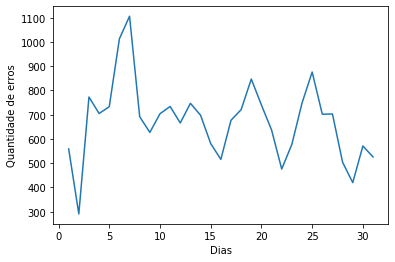

In [212]:
ax = sns.lineplot(x=dias, y=listErro404)
ax.set_xlabel('Dias')
ax.set_ylabel('Quantidade de erros')

## 5. O total de bytes retornados

In [217]:
totalBytes = spSession.sql("SELECT COUNT(TOTAL_BYTES) as TOTAL_BYTES FROM dataset").first()

In [218]:
print("Total de bytes: {}".format(totalBytes[0]))

Total de bytes: 3461612


# FIM